# Occlusion for image segmentation

In [5]:
import numpy as np
import matplotlib.pyplot as plt

import random
import glob
from tqdm import tqdm

import cv2

import torch
from torch.utils.data import DataLoader
from torchvision.transforms.functional import to_pil_image

from captum.attr import Occlusion
from copy import deepcopy

from huggingface_hub import hf_hub_download

# utils
import importlib

import sys
sys.path.append("../")
import utils
importlib.reload(utils)
import network
from datasets import SegmentationDataset

save_path = "../maps/"

In [6]:
def generate_occlusion_map(model, input_image, mask=None, patch_size=5, stride=1):
    """
    Generate an occlusion map for a given image input and specified mask region.

    Args:
    - model (torch.nn.Module): Pre-trained segmentation model.
    - input_image (torch.Tensor): Input image tensor of shape (C, H, W).
    - mask (torch.Tensor): Mask of shape (H, W), with 1s for pixels to analyze, 0s elsewhere.
    - patch_size (int): The size of the occlusion patch.
    - stride (int): Stride for moving the occlusion patch across the image.

    Returns:
    - occlusion_map (np.array): Heatmap of occlusion influence for the masked region.
    """
    
    # Ensure input image and model are on the same device
    input_image = input_image.to(device).unsqueeze(0)  # add batch dimension
    original_pred = model(input_image).squeeze(0)  # model prediction on original image
    original_pred = original_pred.cpu().detach().numpy()
    original_masked_pred = original_pred * mask  # Apply mask to the output

    # Initialize occlusion map
    occlusion_map = np.zeros(input_image.shape[2:])

    # Iterate over image in patches
    for y in tqdm(range(0, input_image.shape[2] - patch_size + 1, stride)):
        for x in range(0, input_image.shape[3] - patch_size + 1, stride):
            # Clone and occlude a patch in the input image
            occluded_image = deepcopy(input_image)
            occluded_image[:, :, y:y + patch_size, x:x + patch_size] = 0  # occlude with zeros

            # Get prediction for the occluded image
            with torch.no_grad():
                occluded_pred = model(occluded_image).squeeze(0)
                occluded_pred = occluded_pred.cpu().detach().numpy()

            # Calculate difference in predictions for the masked region
            occlusion_influence = np.abs(original_masked_pred - (occluded_pred * mask)).sum().item()
            occlusion_map[y:y + patch_size, x:x + patch_size] += occlusion_influence

    # Normalize occlusion map to [0, 1]
    occlusion_map = (occlusion_map - np.min(occlusion_map)) / (np.max(occlusion_map) - np.min(occlusion_map))

    return occlusion_map

def plot_occlusion_map(bands, occlusion_map):
    # Plotting the occlusion map
    plt.figure(figsize=(5, 5))
    nir = bands[3].cpu().detach().numpy()
    plt.imshow(nir, cmap='gray', alpha=0.5)
    plt.imshow(occlusion_map, cmap='hot', alpha=0.6)
    plt.colorbar(label="Influence Score")
    
    plt.xticks([])
    plt.yticks([])

# Load the model and dataset

In [11]:
# Load paths
paths = glob.glob('../../../data/LICS/test/*')
print(len(paths))

100


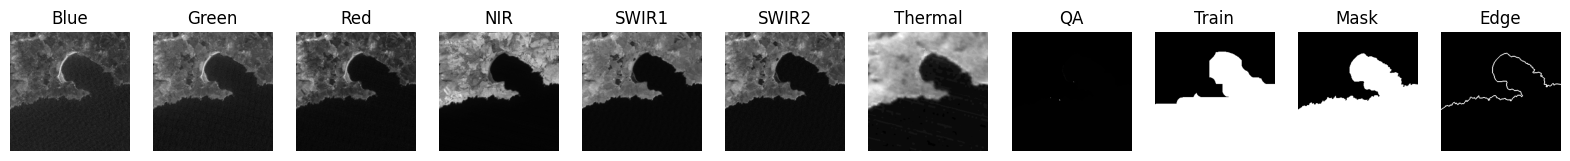

In [12]:
img = np.load(paths[0])
utils.display_bands(img)

In [13]:
# Create dataset object
lics_dataset = SegmentationDataset(paths) 

# Download the model directly from Hugging Face
model_path = hf_hub_download(
    repo_id="a-data-odyssey/coastal-image-segmentation", 
    filename="LICS_UNET_12JUL2024.pth")

# Load the model
model = torch.load(model_path,map_location=torch.device('cpu'))

# Set the model to evaluation mode
device = torch.device('mps' if torch.backends.mps.is_built() 
                      else 'cuda' if torch.cuda.is_available() 
                      else 'cpu')
model.to(device)
model.eval()  

/var/folders/_j/wkrsnnnn2lj6cds3dhhlkkh40000gn/T/ipykernel_42370/2049629126.py:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load(model_path,map_location=t

U_Net(
  (Maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (Conv1): conv_block(
    (conv): Sequential(
      (0): Conv2d(7, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
    )
  )
  (Conv2): conv_block(
    (conv): Sequential(
      (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
    )

torch.Size([2, 256, 256])
torch.Size([1, 2, 256, 256])


/var/folders/_j/wkrsnnnn2lj6cds3dhhlkkh40000gn/T/ipykernel_42370/1347363448.py:26: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  accuracy = np.mean(np.array(target_water == output))


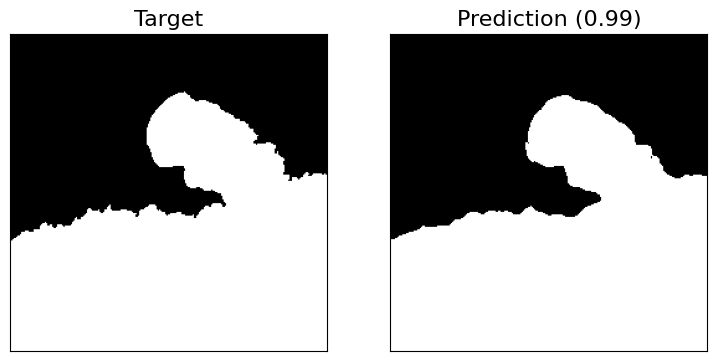

In [14]:
# Load first instance
bands, target, edge = lics_dataset.__getitem__(0)

# Make a prediction
input = bands.to(device)
input = input.unsqueeze(0)
output = model(input)

print(target.shape)
print(output.shape)

# Get the water mask 
target_water = np.argmax(target, axis=0)

# Get the predicted water mask
output = output.cpu().detach().numpy().squeeze()
output = np.argmax(output, axis=0)

# Plot the prediction
fig, axs = plt.subplots(1, 2, figsize=(9, 5))
axs[0].imshow(target_water, cmap='gray')
axs[0].set_title('Target', fontsize=16)

axs[1].imshow(output, cmap='gray')

accuracy = np.mean(np.array(target_water == output))
accuracy = round(accuracy, 3)
axs[1].set_title(f'Prediction ({accuracy})', fontsize=16)

for ax in axs:
    ax.set_xticks([])
    ax.set_yticks([])

(256, 256, 7)
(256, 256, 3)


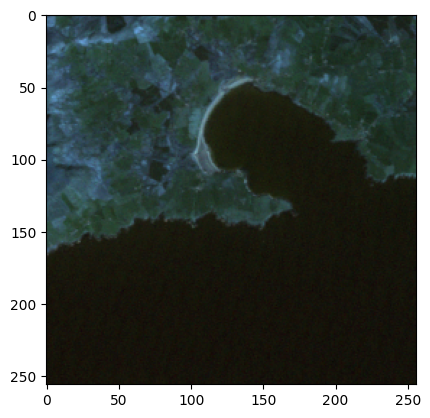

In [59]:
input_image = bands.to(device).unsqueeze(0)

rgb_image = input_image.cpu().detach().numpy().squeeze()
rgb_image = np.moveaxis(rgb_image, 0, -1)
print(rgb_image.shape)
rgb_image = rgb_image[:,:,0:3]
rgb_image = np.clip(rgb_image, 0, 0.3)/0.3
print(rgb_image.shape)


plt.imshow(rgb_image)

In [73]:
occlusion_patch

tensor([[[[0.1886, 0.1886, 0.1886,  ..., 0.1886, 0.1886, 0.1886],
          [0.1886, 0.1886, 0.1886,  ..., 0.1886, 0.1886, 0.1886],
          [0.1886, 0.1886, 0.1886,  ..., 0.1886, 0.1886, 0.1886],
          ...,
          [0.1886, 0.1886, 0.1886,  ..., 0.1886, 0.1886, 0.1886],
          [0.1886, 0.1886, 0.1886,  ..., 0.1886, 0.1886, 0.1886],
          [0.1886, 0.1886, 0.1886,  ..., 0.1886, 0.1886, 0.1886]],

         [[0.4747, 0.4747, 0.4747,  ..., 0.4747, 0.4747, 0.4747],
          [0.4747, 0.4747, 0.4747,  ..., 0.4747, 0.4747, 0.4747],
          [0.4747, 0.4747, 0.4747,  ..., 0.4747, 0.4747, 0.4747],
          ...,
          [0.4747, 0.4747, 0.4747,  ..., 0.4747, 0.4747, 0.4747],
          [0.4747, 0.4747, 0.4747,  ..., 0.4747, 0.4747, 0.4747],
          [0.4747, 0.4747, 0.4747,  ..., 0.4747, 0.4747, 0.4747]],

         [[0.2737, 0.2737, 0.2737,  ..., 0.2737, 0.2737, 0.2737],
          [0.2737, 0.2737, 0.2737,  ..., 0.2737, 0.2737, 0.2737],
          [0.2737, 0.2737, 0.2737,  ..., 0

[[[[0.19]]

  [[0.47]]

  [[0.27]]

  [[0.21]]

  [[0.52]]

  [[0.33]]

  [[0.11]]]]
torch.Size([1, 7, 1, 1])
torch.Size([1, 7, 32, 32])
(256, 256, 7)
(256, 256, 3)


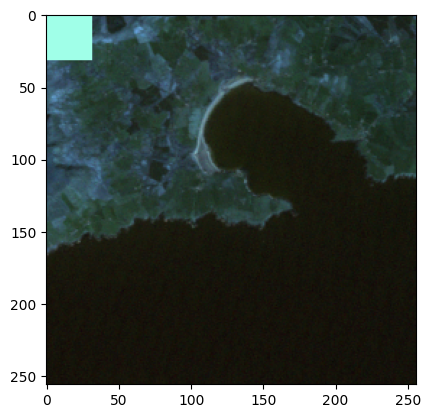

In [72]:
input_image = bands.to(device).unsqueeze(0)
n_channels, height, width = input_image.shape[1:]
patch_size = 32

occlusion_values = occlusion_values = torch.rand((1,n_channels,1,1)) # mean of each channel
print(np.round(occlusion_values.cpu().detach().numpy(),2))

# Create 32 x32 patch 
occlusion_patch = torch.zeros((1,n_channels,patch_size,patch_size))
occlusion_patch += occlusion_values

#occlusion_patch[:, :, :patch_size, :patch_size] = occlusion_values[:, :, None, None]

print(occlusion_values.shape)
print(occlusion_patch.shape)


input_image[:, :, :patch_size, :patch_size] = occlusion_patch

rgb_image = input_image.cpu().detach().numpy().squeeze()
rgb_image = np.moveaxis(rgb_image, 0, -1)
print(rgb_image.shape)
rgb_image = rgb_image[:,:,0:3]
rgb_image = np.clip(rgb_image, 0, 0.3)/0.3
print(rgb_image.shape)

plt.imshow(rgb_image)


(256, 256, 7)


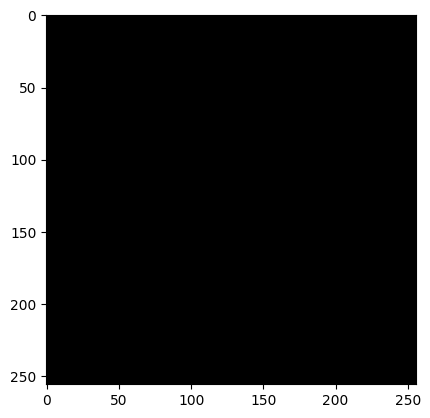

# Image 1 

torch.Size([7, 256, 256])
torch.Size([2, 256, 256])
torch.Size([256, 256])


/var/folders/_j/wkrsnnnn2lj6cds3dhhlkkh40000gn/T/ipykernel_64537/261937980.py:12: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  rgb = utils.get_rgb(np.array(bands),contrast=0.3)


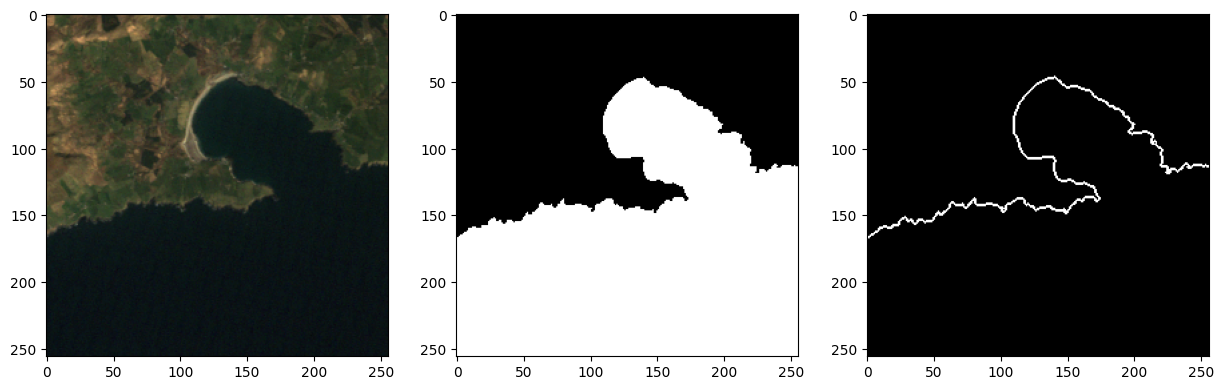

In [7]:
# Load first instance
bands, target, edge = lics_dataset.__getitem__(0)

# Shape of the image
print(bands.shape)
print(target.shape)
print(edge.shape)

# visualise the image
fig, ax = plt.subplots(1, 3, figsize=(15, 5))

rgb = utils.get_rgb(np.array(bands),contrast=0.3)

ax[0].imshow(rgb)
ax[1].imshow(target[1], cmap='gray')
ax[2].imshow(edge, cmap='gray')

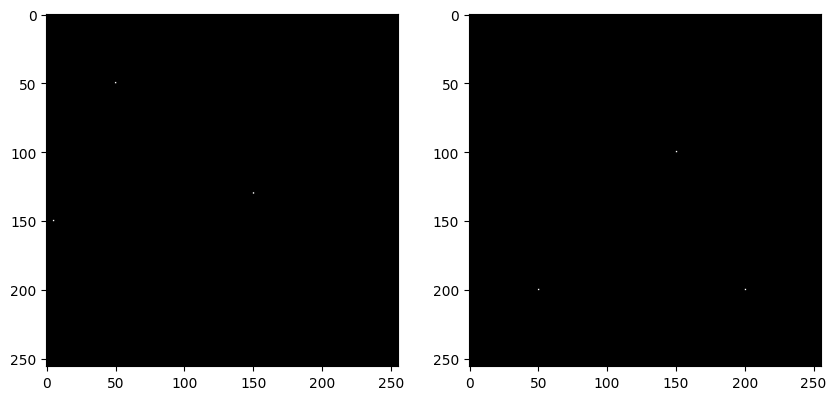

In [47]:
land_pixel = np.zeros_like(target[1])
land_pixel[50, 50] = 1
land_pixel[150, 5] = 1
land_pixel[130, 150] = 1

water_pixel = np.zeros_like(target[1])
water_pixel[200, 200] = 1
water_pixel[100,150] = 1
water_pixel[200,50] = 1

fig,ax = plt.subplots(1,2,figsize=(10,5))

ax[0].imshow(land_pixel,cmap='gray')
ax[1].imshow(water_pixel,cmap='gray')


In [76]:
i = 0
bands, target, edge = lics_dataset.__getitem__(i)

patch_size = 5
stride = 1

# Generate occlusion maps
water_map = generate_occlusion_map(model, bands, water_pixel,patch_size=patch_size,stride=stride)
np.save(save_path + f"water_map_{i}_{patch_size}_{stride}.npy", water_map)

land_map = generate_occlusion_map(model, bands, land_pixel,patch_size=patch_size,stride=stride)
np.save(save_path + f"land_map_{i}_{patch_size}_{stride}.npy", land_map)

mask = edge.cpu().detach().numpy()
coasline_map = generate_occlusion_map(model, bands, mask,patch_size=patch_size,stride=stride)
np.save(save_path + f"coastline_map_{i}_{patch_size}_{stride}.npy", coasline_map)

 43%|████▎     | 109/252 [1:59:42<2:37:03, 65.90s/it] 


KeyboardInterrupt: 

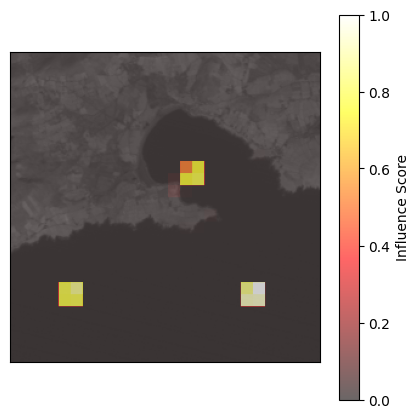

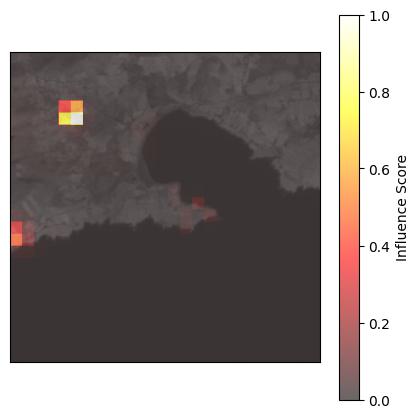

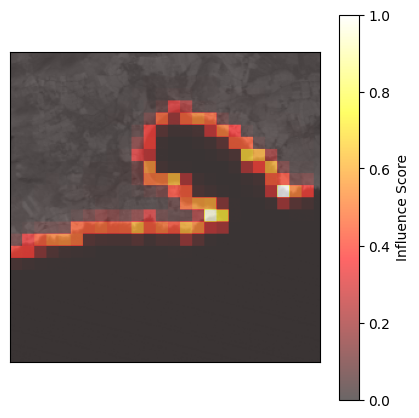

In [45]:
water_map = np.load(save_path + f"water_map_0_10_10.npy")
plot_occlusion_map(bands, water_map)

land_map = np.load(save_path + f"land_map_0_10_10.npy")
plot_occlusion_map(bands, land_map)

coasline_map = np.load(save_path + f"coastline_map_0_10_10.npy")
plot_occlusion_map(bands, coasline_map)

# Image 2

torch.Size([7, 256, 256])
torch.Size([2, 256, 256])
torch.Size([256, 256])


/var/folders/_j/wkrsnnnn2lj6cds3dhhlkkh40000gn/T/ipykernel_64537/2829193367.py:12: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  rgb = utils.get_rgb(np.array(bands),contrast=0.3)


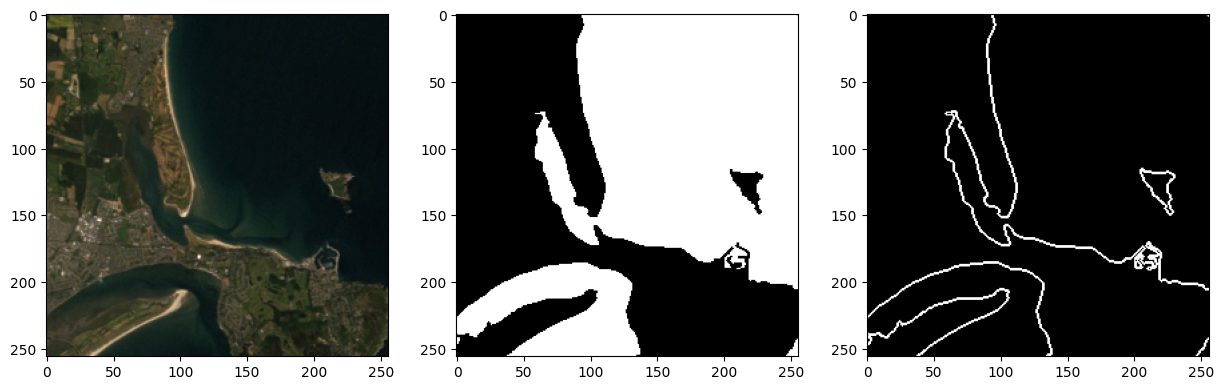

In [57]:
# Load first instance
bands, target, edge = lics_dataset.__getitem__(3)

# Shape of the image
print(bands.shape)
print(target.shape)
print(edge.shape)

# visualise the image
fig, ax = plt.subplots(1, 3, figsize=(15, 5))

rgb = utils.get_rgb(np.array(bands),contrast=0.3)

ax[0].imshow(rgb)
ax[1].imshow(target[1], cmap='gray')
ax[2].imshow(edge, cmap='gray')

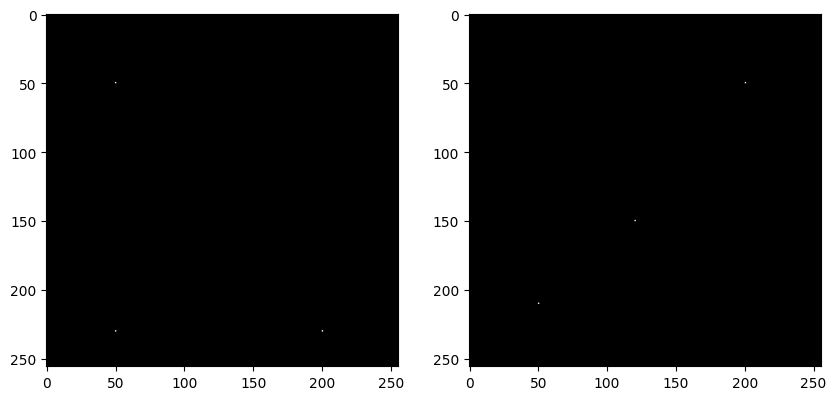

In [61]:
land_pixel = np.zeros_like(target[1])
#land_pixel = np.copy(edge)
land_pixel[230, 50] = 1
land_pixel[230, 200] = 1
land_pixel[50, 50] = 1

water_pixel = np.zeros_like(target[1])
water_pixel[50, 200] = 1
water_pixel[150,120] = 1
water_pixel[210,50] = 1

fig,ax = plt.subplots(1,2,figsize=(10,5))

ax[0].imshow(land_pixel,cmap='gray')
ax[1].imshow(water_pixel,cmap='gray')

In [62]:
i = 3
bands, target, edge = lics_dataset.__getitem__(i)

patch_size = 10
stride = 10

# Generate occlusion maps
water_map = generate_occlusion_map(model, bands, water_pixel,patch_size=patch_size,stride=stride)
np.save(save_path + f"water_map_{i}_{patch_size}_{stride}.npy", water_map)

land_map = generate_occlusion_map(model, bands, land_pixel,patch_size=patch_size,stride=stride)
np.save(save_path + f"land_map_{i}_{patch_size}_{stride}.npy", land_map)

mask = edge.cpu().detach().numpy()
coasline_map = generate_occlusion_map(model, bands, mask,patch_size=patch_size,stride=stride)
np.save(save_path + f"coastline_map_{i}_{patch_size}_{stride}.npy", coasline_map)

100%|██████████| 25/25 [02:10<00:00,  5.20s/it]


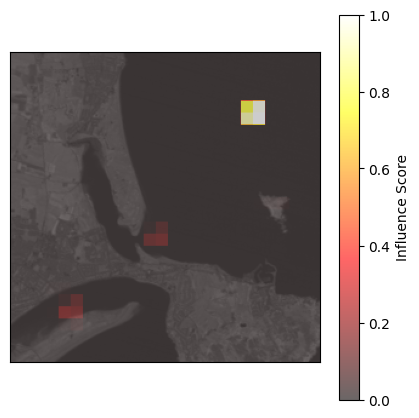

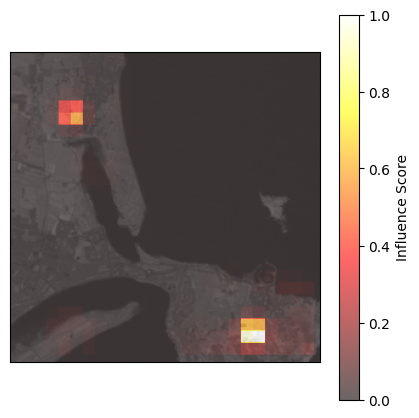

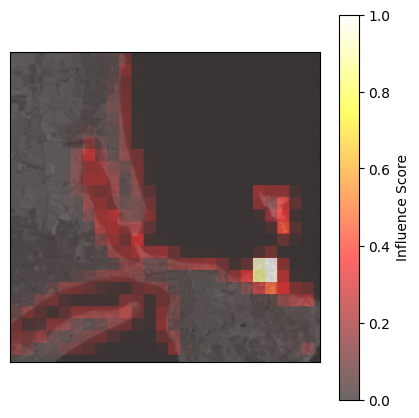

In [63]:
water_map = np.load(save_path + f"water_map_3_10_10.npy")
plot_occlusion_map(bands, water_map)

land_map = np.load(save_path + f"land_map_3_10_10.npy")
plot_occlusion_map(bands, land_map)

coasline_map = np.load(save_path + f"coastline_map_3_10_10.npy")
plot_occlusion_map(bands, coasline_map)

# Image 3

torch.Size([7, 256, 256])
torch.Size([2, 256, 256])
torch.Size([256, 256])


/var/folders/_j/wkrsnnnn2lj6cds3dhhlkkh40000gn/T/ipykernel_64537/1640181516.py:12: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  rgb = utils.get_rgb(np.array(bands),contrast=0.3)


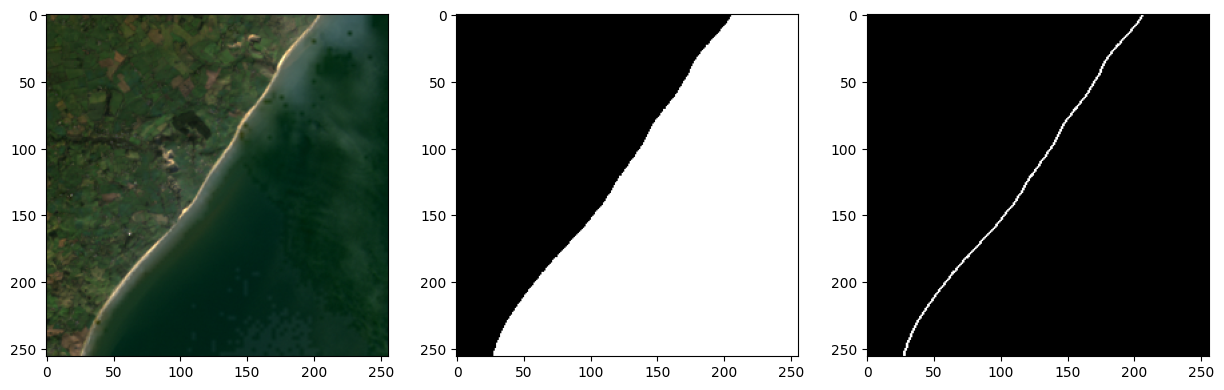

In [72]:
# Load first instance
bands, target, edge = lics_dataset.__getitem__(5)

# Shape of the image
print(bands.shape)
print(target.shape)
print(edge.shape)

# visualise the image
fig, ax = plt.subplots(1, 3, figsize=(15, 5))

rgb = utils.get_rgb(np.array(bands),contrast=0.3)

ax[0].imshow(rgb)
ax[1].imshow(target[1], cmap='gray')
ax[2].imshow(edge, cmap='gray')

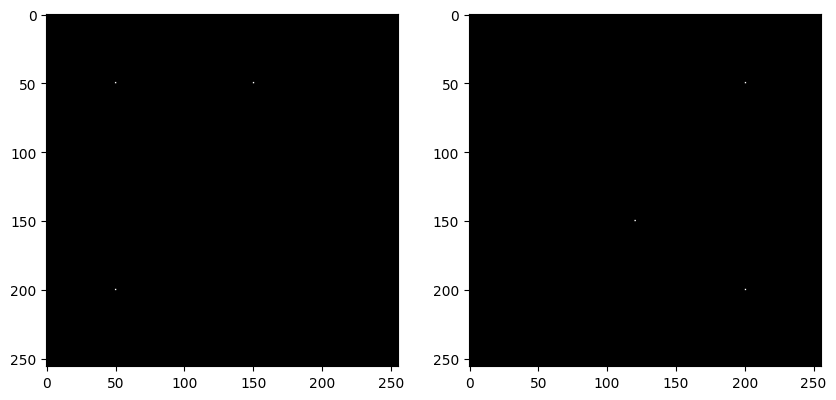

In [73]:
land_pixel = np.zeros_like(target[1])
#land_pixel = np.copy(edge)
land_pixel[200, 50] = 1
land_pixel[50, 150] = 1
land_pixel[50, 50] = 1

water_pixel = np.zeros_like(target[1])
#water_pixel = np.copy(edge)
water_pixel[50, 200] = 1
water_pixel[150,120] = 1
water_pixel[200,200] = 1

fig,ax = plt.subplots(1,2,figsize=(10,5))

ax[0].imshow(land_pixel,cmap='gray')
ax[1].imshow(water_pixel,cmap='gray')

In [74]:
i = 5
bands, target, edge = lics_dataset.__getitem__(i)

patch_size = 10
stride = 10

# Generate occlusion maps
water_map = generate_occlusion_map(model, bands, water_pixel,patch_size=patch_size,stride=stride)
np.save(save_path + f"water_map_{i}_{patch_size}_{stride}.npy", water_map)

land_map = generate_occlusion_map(model, bands, land_pixel,patch_size=patch_size,stride=stride)
np.save(save_path + f"land_map_{i}_{patch_size}_{stride}.npy", land_map)

mask = edge.cpu().detach().numpy()
coasline_map = generate_occlusion_map(model, bands, mask,patch_size=patch_size,stride=stride)
np.save(save_path + f"coastline_map_{i}_{patch_size}_{stride}.npy", coasline_map)

100%|██████████| 25/25 [01:58<00:00,  4.76s/it]


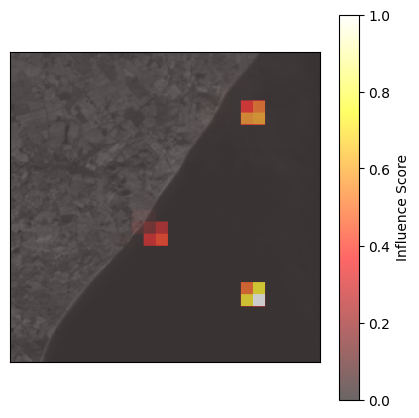

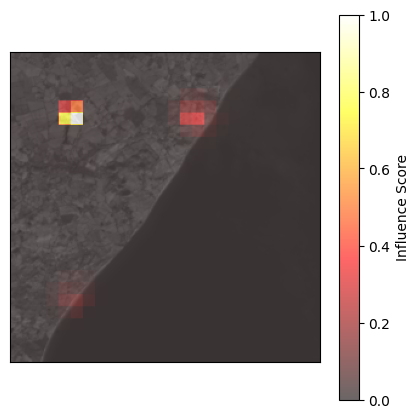

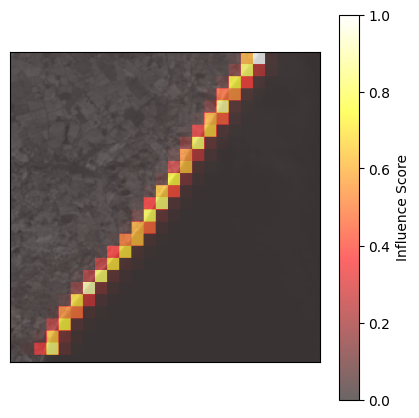

In [75]:
water_map = np.load(save_path + f"water_map_5_10_10.npy")
plot_occlusion_map(bands, water_map)

land_map = np.load(save_path + f"land_map_5_10_10.npy")
plot_occlusion_map(bands, land_map)

coasline_map = np.load(save_path + f"coastline_map_5_10_10.npy")
plot_occlusion_map(bands, coasline_map)

# Archive

In [45]:
mask = edge.cpu().detach().numpy()
# Ensure input image and model are on the same device
input_image = bands.to(device).unsqueeze(0)  # add batch dimension
original_pred = model(input_image).squeeze(0)  # model prediction on original image
original_pred = original_pred.cpu().detach().numpy()
original_masked_pred = original_pred * mask  # Apply mask to the output

In [47]:
print(original_pred.shape)
print(original_masked_pred.shape)

(2, 256, 256)
(2, 256, 256)


In [48]:
# Initialize occlusion map
occlusion_map = np.zeros(input_image.shape[2:])

print(occlusion_map.shape)

(256, 256)


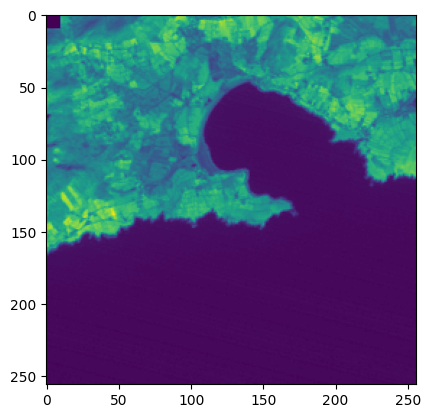

In [65]:
y = 0
x = 0
patch_size = 10
occluded_image = deepcopy(input_image)
occluded_image[:, :, y:y + patch_size, x:x + patch_size] = 0  # occlude with zeros

nir = occluded_image[0][3].cpu().detach().numpy()
plt.imshow(nir)

In [66]:
with torch.no_grad():
    occluded_pred = model(occluded_image).squeeze(0)
    occluded_pred = occluded_pred.cpu().detach().numpy()

In [67]:
differnece = np.abs(original_masked_pred - (occluded_pred * mask))
occlusion_influence = differnece.sum().item()

print(occluded_pred.shape)
print(differnece.shape)
print(occlusion_influence)


(2, 256, 256)
(2, 256, 256)
3.603752702474594e-06


In [68]:
# Iterate over image in patches
for y in tqdm(range(0, input_image.shape[2] - patch_size + 1, stride)):
    for x in range(0, input_image.shape[3] - patch_size + 1, stride):
        # Clone and occlude a patch in the input image
        
        # Get prediction for the occluded image
        

        # Calculate difference in predictions for the masked region
        
        occlusion_map[y:y + patch_size, x:x + patch_size] += occlusion_influence

# Normalize occlusion map to [0, 1]
occlusion_map = (occlusion_map - np.min(occlusion_map)) / (np.max(occlusion_map) - np.min(occlusion_map))

NameError: name 'stride' is not defined

100%|██████████| 51/51 [06:50<00:00,  8.06s/it]


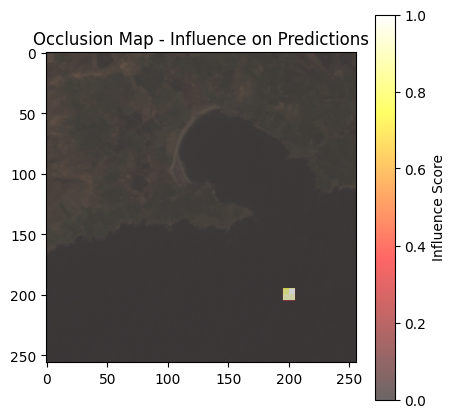

100%|██████████| 51/51 [06:49<00:00,  8.04s/it]


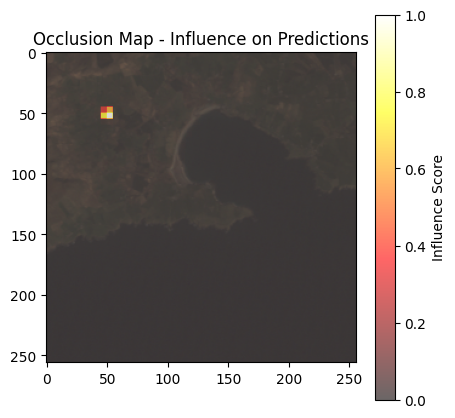

In [41]:
# Generate occlusion map using Captum
occlusion_map = generate_occlusion_map(model, bands, land_pixel,patch_size=5,stride=5)

# Plotting the occlusion map
plt.figure(figsize=(5, 5))
plt.imshow(rgb, cmap='gray', alpha=0.5)
plt.imshow(occlusion_map, cmap='hot', alpha=0.6)
plt.colorbar(label="Influence Score")
plt.title("Occlusion Map - Influence on Predictions")
plt.show()

100%|██████████| 51/51 [07:00<00:00,  8.25s/it]


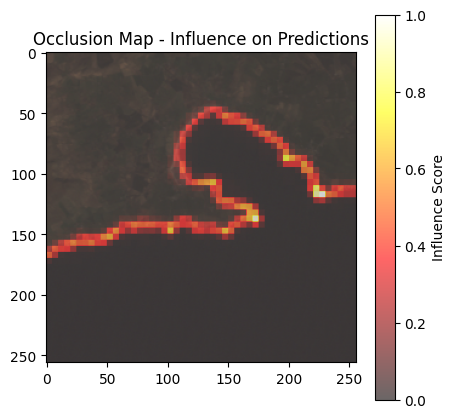

In [43]:
# Generate occlusion map using Captum
coastline = edge.cpu().detach().numpy()
occlusion_map = generate_occlusion_map(model, bands, coastline,patch_size=5,stride=5)

# Plotting the occlusion map
plt.figure(figsize=(5, 5))
plt.imshow(rgb, cmap='gray', alpha=0.5)
plt.imshow(occlusion_map, cmap='hot', alpha=0.6)
plt.colorbar(label="Influence Score")
plt.title("Occlusion Map - Influence on Predictions")
plt.show()

In [ ]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from copy import deepcopy
from torchvision.transforms.functional import to_pil_image


# Load and prepare the data
input_image, target = lics_dataset.__getitem__(0)
mask = torch.zeros_like(target, dtype=torch.float32)
mask[target == 1] = 1  # Example: focus on ocean pixels

# Generate occlusion map for masked pixels
occlusion_map = generate_occlusion_map(model, input_image, mask)

# Plotting the occlusion map
plt.figure(figsize=(10, 10))
plt.imshow(to_pil_image(input_image), cmap='gray', alpha=0.5)
plt.imshow(occlusion_map, cmap='hot', alpha=0.6)
plt.colorbar(label="Influence Score")
plt.title("Occlusion Map - Influence on Predictions")
plt.show()


In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from captum.attr import Occlusion
from skimage.segmentation import slic
from skimage.color import label2rgb
from torchvision.transforms.functional import to_pil_image

def generate_superpixel_occlusion_map(model, input_image, mask=None, n_segments=50):
    """
    Generate an occlusion map using superpixels as occlusion regions.
    
    Args:
    - model (torch.nn.Module): Pre-trained segmentation model.
    - input_image (torch.Tensor): Input image tensor of shape (C, H, W).
    - mask (torch.Tensor): Mask of shape (H, W), with 1s for pixels to analyze, 0s elsewhere.
    - n_segments (int): Number of superpixels to generate.
    
    Returns:
    - occlusion_map (np.array): Heatmap of occlusion influence for the masked region.
    """
    # Convert input tensor to numpy for superpixel segmentation
    input_image_np = input_image.permute(1, 2, 0).cpu().numpy()
    
    # Generate superpixels
    superpixels = slic(input_image_np, n_segments=n_segments, start_label=0)
    num_superpixels = superpixels.max() + 1
    
    # Initialize occlusion map
    occlusion_map = np.zeros(superpixels.shape)
    
    # Define baseline as a zero image (same size as input)
    baseline = torch.zeros_like(input_image).unsqueeze(0).to(device)
    
    # Loop over each superpixel to occlude it
    for sp in range(num_superpixels):
        # Create a mask for the current superpixel
        sp_mask = torch.tensor(superpixels == sp, dtype=torch.float32).unsqueeze(0).to(device)
        
        # Occlude the superpixel region by setting it to the baseline
        occluded_image = input_image.clone().unsqueeze(0).to(device)
        occluded_image[0][:, sp_mask.bool()] = 0  # Occlude with zero baseline

        # Make predictions for occluded image
        with torch.no_grad():
            original_pred = model(input_image.unsqueeze(0).to(device)).squeeze(0) * mask.to(device)
            occluded_pred = model(occluded_image).squeeze(0) * mask.to(device)
        
        # Calculate the influence score for this superpixel
        influence_score = torch.abs(original_pred - occluded_pred).sum().item()
        occlusion_map[superpixels == sp] = influence_score
    
    # Normalize occlusion map to [0, 1]
    occlusion_map = (occlusion_map - np.min(occlusion_map)) / (np.max(occlusion_map) - np.min(occlusion_map))
    
    return occlusion_map

# Load and prepare the data
input_image, target = lics_dataset.__getitem__(0)
mask = torch.zeros_like(target, dtype=torch.float32)
mask[target == 1] = 1  # Example: focus on ocean pixels

# Generate occlusion map using superpixels
occlusion_map = generate_superpixel_occlusion_map(model, input_image, mask)

# Plotting the occlusion map with superpixel boundaries
plt.figure(figsize=(10, 10))
plt.imshow(label2rgb(superpixels, input_image.permute(1, 2, 0).cpu().numpy(), kind='avg'), alpha=0.5)
plt.imshow(occlusion_map, cmap='hot', alpha=0.6)
plt.colorbar(label="Influence Score")
plt.title("Superpixel Occlusion Map - Influence on Predictions")
plt.show()


In [ ]:
def generate_occlusion_map(model, input_image, mask=None, sliding_window=5, stride=1):
    """
    Generate an occlusion map using Captum for a given input image and mask.
    
    Args:
    - model (torch.nn.Module): Pre-trained segmentation model.
    - input_image (torch.Tensor): Input image tensor of shape (C, H, W).
    - mask (torch.Tensor): Mask of shape (H, W), with 1s for pixels to analyze, 0s elsewhere.
    - sliding_window (int): Size of the occlusion patch.
    - stride (int): Stride for moving the occlusion patch across the image.
    
    Returns:
    - occlusion_map (np.array): Heatmap of occlusion influence for the masked region.
    """
    # Ensure input image and model are on the same device
    input_image = input_image.to(device).unsqueeze(0)  # Add batch dimension

    # Initialize Captum Occlusion object
    occlusion = Occlusion(model)
    
    # Generate occlusion attributions for the specified output class (0 or 1 for land or ocean)
    attributions = occlusion.attribute(
        input_image,
        target=0,  # Index for land/ocean prediction, adjust as needed
        sliding_window_shapes=(input_image.shape[1], sliding_window, sliding_window),
        strides=(input_image.shape[1], stride, stride),
        baselines=0
    )
    
    # Convert attributions to numpy and apply mask to occlude only specified areas
    occlusion_map = attributions.squeeze().cpu().numpy()
    if mask is not None:
        occlusion_map = occlusion_map * mask.cpu().numpy()
    
    # Normalize occlusion map to [0, 1]
    occlusion_map = (occlusion_map - np.min(occlusion_map)) / (np.max(occlusion_map) - np.min(occlusion_map))
    
    return occlusion_map